In [1]:
from nowcasting_dataset.datamodule import NowcastingDataModule
from pathlib import Path

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
BUCKET = Path('solar-pv-nowcasting-data')

# Solar PV data
PV_PATH = BUCKET / 'PV/PVOutput.org'
PV_DATA_FILENAME = PV_PATH / 'UK_PV_timeseries_batch.nc'
PV_METADATA_FILENAME = PV_PATH / 'UK_PV_metadata.csv'

# SAT_FILENAME = BUCKET / 'satellite/EUMETSAT/SEVIRI_RSS/OSGB36/all_zarr_int16_single_timestep_quarter_geospatial.zarr'
SAT_FILENAME = BUCKET / 'satellite/EUMETSAT/SEVIRI_RSS/OSGB36/all_zarr_int16_single_timestep.zarr'

In [4]:
%%time
data_module = NowcastingDataModule(
    pv_power_filename=PV_DATA_FILENAME,
    pv_metadata_filename=f'gs://{PV_METADATA_FILENAME}',
    batch_size = 32,
    history_len = 0,  #: Number of timesteps of history, not including t0.
    forecast_len = 1,  #: Number of timesteps of forecast.
    sat_filename = f'gs://{SAT_FILENAME}',
    sat_channels = None, #('HRV', 'WV_062', 'WV_073'),
    pin_memory = True,  #: Passed to DataLoader.
    num_workers = 8,  #: Passed to DataLoader.
    prefetch_factor = 256,  #: Passed to DataLoader.
    n_samples_per_timestep = 8,  #: Passed to NowcastingDataset
)

CPU times: user 54 µs, sys: 10 µs, total: 64 µs
Wall time: 66 µs


In [5]:
%%time
data_module.prepare_data()

15 bad PV systems found and removed!
pv_power = 400.0 MB
CPU times: user 57.7 s, sys: 3.63 s, total: 1min 1s
Wall time: 1min 1s


In [6]:
%%time
data_module.setup()

/home/jack/miniconda3/envs/nowcasting_dataset/lib/python3.9/site-packages/pvlib/solarposition.py:368: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  unixtime = np.array(time.astype(np.int64)/10**9)
/home/jack/miniconda3/envs/nowcasting_dataset/lib/python3.9/site-packages/pvlib/solarposition.py:368: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  unixtime = np.array(time.astype(np.int64)/10**9)
/home/jack/miniconda3/envs/nowcasting_dataset/lib/python3.9/site-packages/pvlib/solarposition.py:368: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  unixtime = np.array(time.astype(np.int64)/10**9)
/home/jack/miniconda3/envs/nowcasting_dataset/lib/python3.9/site-packages/pvlib/solarposition.py:368: F

CPU times: user 8.56 s, sys: 136 ms, total: 8.69 s
Wall time: 9.03 s


/home/jack/dev/ocf/nowcasting_dataset/nowcasting_dataset/utils.py:20: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  a = a.astype(int)


## Define very simple ML model

In [7]:
def normalise_images_in_model(images, device):
    SAT_IMAGE_MEAN = torch.tensor(
        [
            93.23458, 131.71373, 843.7779 , 736.6148 , 771.1189 , 589.66034,
            862.29816, 927.69586,  90.70885, 107.58985, 618.4583 , 532.47394
        ],
        dtype=torch.float, device=device)
    SAT_IMAGE_STD = torch.tensor(
        [
            115.34247 , 139.92636 ,  36.99538 ,  57.366386,  30.346825,
            149.68007 ,  51.70631 ,  35.872967, 115.77212 , 120.997154,
            98.57828 ,  99.76469
        ],
        dtype=torch.float, device=device)
    
    images = images.float()
    images = images - SAT_IMAGE_MEAN.unsqueeze(-1).unsqueeze(-1)
    images = images / SAT_IMAGE_STD.unsqueeze(-1).unsqueeze(-1)
    return images

In [8]:
CHANNELS = 144
KERNEL = 3


class LitAutoEncoder(pl.LightningModule):
    def __init__(
        self,
        history_len: int=1
    ):
        super().__init__()
        self.history_len = history_len
        
        self.encoder_conv1 = nn.Conv2d(in_channels=12, out_channels=CHANNELS//2, kernel_size=KERNEL, groups=12)
        self.encoder_conv2 = nn.Conv2d(in_channels=CHANNELS//2, out_channels=CHANNELS, kernel_size=KERNEL, groups=CHANNELS//2)
        self.encoder_conv3 = nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=KERNEL, groups=CHANNELS)

        self.maxpool = nn.MaxPool2d(kernel_size=KERNEL)
        
        self.fc1 = nn.Linear(
            in_features=CHANNELS * 11 * 11, 
            out_features=256 - 16 # Minus 16 for the embedding_dim.
        )
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=128)
        self.fc5 = nn.Linear(in_features=128, out_features=1)
        
        self.pv_system_id_embedding = nn.Embedding(
            num_embeddings=len(data_module.pv_data_source.pv_metadata),
            embedding_dim=16
        )

        
    def forward(self, x):
        images = x['sat_data'][:, self.history_len, :, :, :]
        images = images.permute(0, 3, 2, 1)  # Conv2d expects channels to be the 2nd dim!
        images = normalise_images_in_model(images, self.device)
        
        # Pass data through the network :)
        out = F.relu(self.encoder_conv1(images))
        out = self.maxpool(out)
        out = F.relu(self.encoder_conv2(out))
        out = self.maxpool(out)
        out = F.relu(self.encoder_conv3(out))
        
        out = out.view(-1, CHANNELS * 11 * 11)
        out = F.relu(self.fc1(out))
        
        pv_embedding = self.pv_system_id_embedding(x['pv_system_row_number'])
        
        out = torch.cat(
            (
                out,
                pv_embedding
                #(x['nwp_above_pv'][:, 0] - 130) / 5,  # TODO fix horrible standardisation of temperature!
            ), dim=1)

        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = self.fc5(out)

        return out
    
    def _training_or_validation_step(self, batch, is_train_step):
        y_hat = self(batch)
        y = batch['pv_yield'][:, self.history_len:]
        #y = torch.rand((32, 1), device=self.device)
        #mse_loss = F.mse_loss(y_hat, y)
        mae_loss = (y_hat - y).abs().mean()
        tag = "Train" if is_train_step else "Validation"
        #self.log_dict({'MSE/' + tag: mse_loss}, on_step=is_train_step, on_epoch=True)
        self.log_dict({'MAE/' + tag: mae_loss}, on_step=is_train_step, on_epoch=True)
        return mae_loss

    def training_step(self, batch, batch_idx):
        return self._training_or_validation_step(batch, is_train_step=True)
    
    def validation_step(self, batch, batch_idx):
        return self._training_or_validation_step(batch, is_train_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [9]:
model = LitAutoEncoder()

In [10]:
model.load_state_dict(torch.load('model_state_dict.pt'))
model.eval()

LitAutoEncoder(
  (encoder_conv1): Conv2d(12, 72, kernel_size=(3, 3), stride=(1, 1), groups=12)
  (encoder_conv2): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), groups=72)
  (encoder_conv3): Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), groups=144)
  (maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=17424, out_features=240, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=1, bias=True)
  (pv_system_id_embedding): Embedding(940, 16)
)

In [11]:
%%time
contig_dataloader = data_module.contiguous_dataloader()

CPU times: user 1.26 ms, sys: 76 µs, total: 1.33 ms
Wall time: 171 µs


In [12]:
%%time
data_module.contiguous_dataset.per_worker_init(worker_id=1)

CPU times: user 2.8 s, sys: 67.9 ms, total: 2.86 s
Wall time: 1.76 s


In [13]:
t0_datetimes = data_module.contiguous_dataset._get_t0_datetimes_for_batch()
t0_datetimes

DatetimeIndex(['2019-07-11 16:25:00', '2019-07-11 16:30:00',
               '2019-07-11 16:35:00', '2019-07-11 16:40:00',
               '2019-07-11 16:45:00', '2019-07-11 16:50:00',
               '2019-07-11 16:55:00', '2019-07-11 17:00:00',
               '2019-07-11 17:05:00', '2019-07-11 17:10:00',
               '2019-07-11 17:15:00', '2019-07-11 17:20:00',
               '2019-07-11 17:25:00', '2019-07-11 17:30:00',
               '2019-07-11 17:35:00', '2019-07-11 17:40:00',
               '2019-07-11 17:45:00', '2019-07-11 17:50:00',
               '2019-07-11 17:55:00', '2019-07-11 18:00:00',
               '2019-07-11 18:05:00', '2019-07-11 18:10:00',
               '2019-07-11 18:15:00', '2019-07-11 18:20:00',
               '2019-07-11 18:25:00', '2019-07-11 18:30:00',
               '2019-07-11 18:35:00', '2019-07-11 18:40:00',
               '2019-07-11 18:45:00', '2019-07-11 18:50:00',
               '2019-07-11 18:55:00', '2019-07-11 19:00:00'],
              dtype='da

In [14]:
locations = data_module.contiguous_dataset._get_locations_for_batch(t0_datetimes)
locations

(array([199432.99699918, 199432.99699918, 199432.99699918, 199432.99699918,
        199432.99699918, 199432.99699918, 199432.99699918, 199432.99699918,
        199432.99699918, 199432.99699918, 199432.99699918, 199432.99699918,
        199432.99699918, 199432.99699918, 199432.99699918, 199432.99699918,
        199432.99699918, 199432.99699918, 199432.99699918, 199432.99699918,
        199432.99699918, 199432.99699918, 199432.99699918, 199432.99699918,
        199432.99699918, 199432.99699918, 199432.99699918, 199432.99699918,
        199432.99699918, 199432.99699918, 199432.99699918, 199432.99699918]),
 array([52701.11181601, 52701.11181601, 52701.11181601, 52701.11181601,
        52701.11181601, 52701.11181601, 52701.11181601, 52701.11181601,
        52701.11181601, 52701.11181601, 52701.11181601, 52701.11181601,
        52701.11181601, 52701.11181601, 52701.11181601, 52701.11181601,
        52701.11181601, 52701.11181601, 52701.11181601, 52701.11181601,
        52701.11181601, 52701.

In [171]:
contig_batch = data_module.contiguous_dataset._get_batch()

In [172]:
contig_batch['pv_system_id']

tensor([52840, 52840, 52840, 52840, 52840, 59984, 59984, 52840, 59984, 59984,
        59984, 52840, 52840, 52840, 59984, 52840, 52840, 52840, 59984, 59984,
        59984, 52840, 59984, 59984, 52840, 59984, 52840, 59984, 59984, 52840,
        52840, 52840])

In [173]:
model_output = model(contig_batch)

In [174]:
dt_index = pd.to_datetime(contig_batch['t0_dt'].numpy(), unit='s')

In [175]:
dt_index

DatetimeIndex(['2019-08-18 05:00:00', '2019-08-18 05:05:00',
               '2019-08-18 05:10:00', '2019-08-18 05:15:00',
               '2019-08-18 05:20:00', '2019-08-18 05:25:00',
               '2019-08-18 05:30:00', '2019-08-18 05:35:00',
               '2019-08-18 05:40:00', '2019-08-18 05:45:00',
               '2019-08-18 05:50:00', '2019-08-18 05:55:00',
               '2019-08-18 06:00:00', '2019-08-18 06:05:00',
               '2019-08-18 06:10:00', '2019-08-18 06:15:00',
               '2019-08-18 06:20:00', '2019-08-18 06:25:00',
               '2019-08-18 06:30:00', '2019-08-18 06:35:00',
               '2019-08-18 06:40:00', '2019-08-18 06:45:00',
               '2019-08-18 06:50:00', '2019-08-18 06:55:00',
               '2019-08-18 07:00:00', '2019-08-18 07:05:00',
               '2019-08-18 07:10:00', '2019-08-18 07:15:00',
               '2019-08-18 07:20:00', '2019-08-18 07:25:00',
               '2019-08-18 07:30:00', '2019-08-18 07:35:00'],
              dtype='da

Text(0.5, 1.0, '2019-08-18 07:35:00')

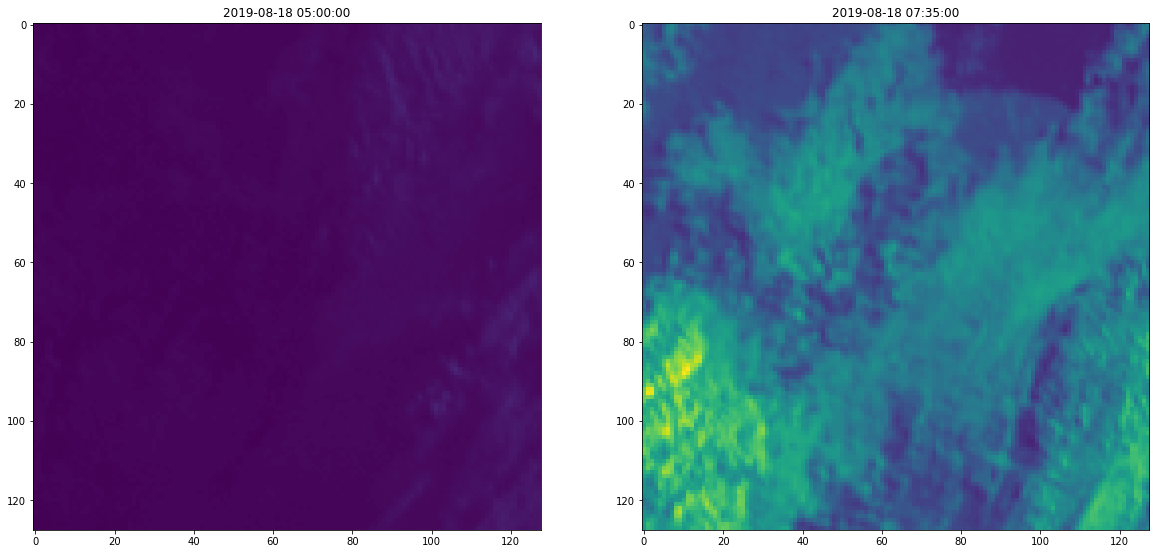

In [176]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))

sat_channel = 0
sat_data = contig_batch['sat_data'][:, 1, :, :, sat_channel]
sat_min, sat_max = sat_data.min(), sat_data.max()

ax = axes[0]
ax.imshow(sat_data[0], vmin=sat_min, vmax=sat_max)
ax.set_title(dt_index[0])

ax = axes[1]
ax.imshow(sat_data[-1], vmin=sat_min, vmax=sat_max)
ax.set_title(dt_index[-1])

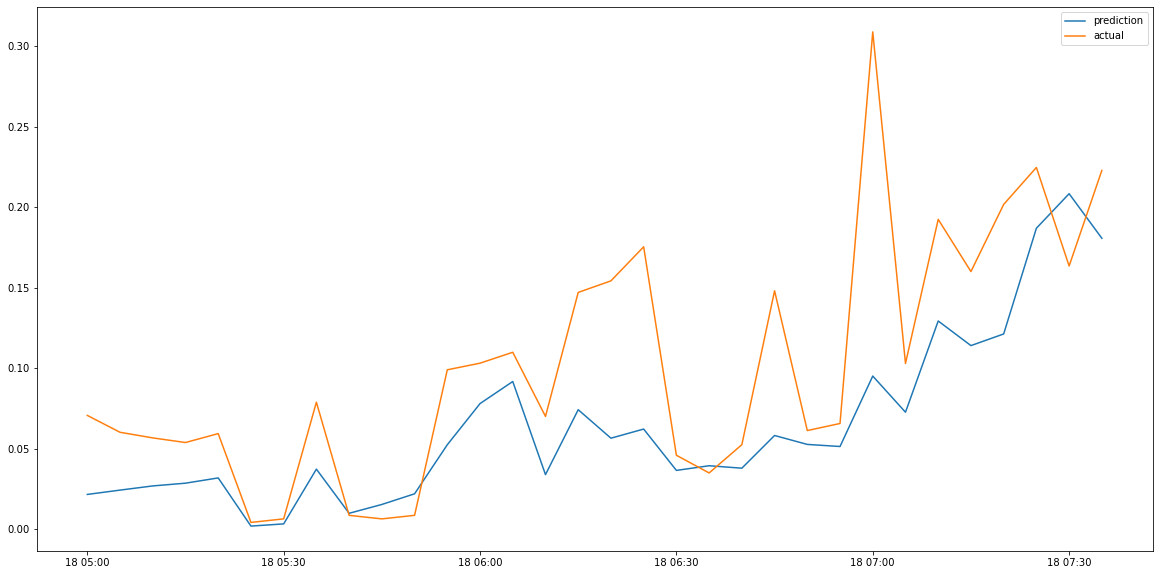

In [177]:
fig, ax = plt.subplots(figsize=(20, 10))
pred = pd.Series(model_output.detach().numpy().flatten(), index=dt_index)
ax.plot(pred, label='prediction')
actual = pd.Series(contig_batch['pv_yield'][:, 1], index=dt_index)
ax.plot(actual, label='actual')
ax.legend();